In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from fjd.fjd_metric import FJDMetric
from fjd.embeddings import OneHotEmbedding, InceptionEmbedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


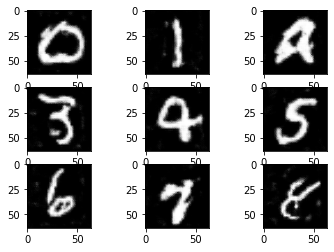

In [2]:
c_dim = 10
v_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ## Decoding:
        self.deconv1v = nn.ConvTranspose2d(v_dim, 1024, 4, 1, 0, bias = False) # Not sure how this looks
        self.deconv1c = nn.ConvTranspose2d(c_dim, 1024, 4, 1, 0, bias = False) # Input: (bs, cdim+v_dim, 1, 1)
        
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024+1024, 512, 4, 2, 1, bias = False)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)
    
    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
      
    def forward(self, v, c):
        v = self.deconv1_bn(self.deconv1v(v))
        c = self.deconv1_bn(self.deconv1c(c))
        x = torch.cat((v, c), dim = 1) #stack on channel dim, should be (bs, vdim+cdim, 1, 1). Not sure here
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))
        return x
    
G = Generator().to(device)
G.load_state_dict(torch.load('models/cgan_mnist_G.pt'))

def one_hot_embedding(labels):
    #y = torch.eye(num_classes)
    #return y[labels]
    #return torch.nn.functional.one_hot(labels)[:,1:]
    
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)

def print_g_sample():
    with torch.no_grad():
        codes = one_hot_embedding(torch.tensor(list(range(9)), device = device)).view(9,c_dim,1,1).float()
        varis = torch.randn((9, v_dim,1,1), device = device) # walk from [0,...,0] to [1,...,1]
        generated = .5*(G(varis, codes).cpu() + 1)
        generated = torch.squeeze(generated)
        #print(generated.shape)
        for i in range(9):
            plt.subplot(330 + 1 + i)
            # plot raw pixel data
            element = generated[i,:]
            plt.imshow(element, cmap = 'gray')
        plt.show()
        
print_g_sample()

In [3]:
def get_dataloaders():
    #transform = transforms.Compose(
    #    [transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.5, 0.5, 0.5), 
    #                          std=(0.5, 0.5, 0.5))])
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], 
                              std=[0.5])])

    train_set = MNIST(root='./data',
                        train=True,
                        download=True,
                        transform=transform)

    test_set = MNIST(root='./data',
                       train=False,
                       download=True,
                       transform=transform)

    train_loader = DataLoader(train_set,
                              batch_size=128,
                              shuffle=True,
                              drop_last=False)

    test_loader = DataLoader(test_set,
                             batch_size=128,
                             shuffle=False,
                             drop_last=False)
    
    x = next(iter(train_loader))
    print(x[0].shape)
    print(x[1].shape)
    print(torch.min(x[0]), torch.max(x[0]))

    return train_loader, test_loader

#print_g_sample()

In [4]:
## My GANWrapper
class GANWrapper:
    def __init__(self, model, model_checkpoint=None):
        self.model = model
        
        if model_checkpoint is not None:
            self.model_checkpoint = model_checkpoint
            self.load_model()
         
        # model weights are loaded correctly...
        #print(self.model.deconv1v.weight)

    def load_model(self):
        self.model.eval()  # uncomment to put in eval mode if desired
        self.model = self.model.cuda()
        
        state_dict = torch.load(self.model_checkpoint)
        #self.model.load_state_dict(torch.load('models/caegan_mnist_G.pt'))

    def get_noise(self, batch_size):
        # change the noise dimension as required
        #z = torch.randn((batch_size, v_dim, 1, 1), device = device)
        pass
    
    def print_sample(self):
        print_g_sample()

    def __call__(self, y):
        #print(y.shape)
        #print(y[0])
        #print(y.shape)
        #print(y[0])
        batch_size = y.size(0)
        y = onehot_embedding(y).to(device).view(batch_size, c_dim, 1, 1)

        # = one_hot_embedding(y).view(batch_size, c_dim, 1, 1).to(device).float()
        #y = one_hot_embedding(torch.randint(10, (batch_size, 1), device = device)).view(batch_size,c_dim,1,1).float()
        z = torch.randn((batch_size, v_dim, 1, 1), device = device)
        samples = G(z, y)
        
        #print('In call, first 9 returning images: ')
        #print(self.model.deconv1.weight)
        #for i in range(9):
        #    plt.subplot(330 + 1 + i)
        #    # plot raw pixel data
        #    element = samples[i,:].cpu().permute(1,2,0)
        #    plt.imshow(element, cmap = 'gray')
        #plt.show()
        
        #self.print_sample()
        #plt.imshow(samples[0].permute(1,2,0).cpu())
        
        return samples
    
#print_g_sample()

In [5]:
train_loader, test_loader = get_dataloaders()
inception_embedding = InceptionEmbedding(parallel=False)
onehot_embedding = OneHotEmbedding(num_classes=10)
#gan = SuspiciouslyGoodGAN()
gan = Generator()
params = 'models/cgan_mnist_G.pt'
gan = GANWrapper(model = gan, model_checkpoint = params)
#gan.print_sample()


torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(-1.) tensor(1.)


In [6]:
fjd_metric = FJDMetric(gan=gan,
                       reference_loader=train_loader, #mnist train
                       condition_loader=test_loader, #mnist test
                       image_embedding=inception_embedding, #dont change
                       condition_embedding=onehot_embedding,
                       reference_stats_path='datasets/cifar_train_stats.npz',
                       save_reference_stats=True,
                       samples_per_condition=1,
                       cuda=True)

In [7]:
fid = fjd_metric.get_fid()
fjd = fjd_metric.get_fjd()
print('FID: ', fid)
print('FJD: ', fjd)

Computing generated distribution:   0%|                                                         | 0/79 [00:00<?, ?it/s]

Loading reference statistics from datasets/cifar_train_stats.npz


Computing generated distribution: 100%|████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.52it/s]


FID:  189.5352083117636
FJD:  227.92492793112297
